# Data Science in Practice 2020

## Problem Set 2

### Descriptive report

Authors :
- Rayan Chaouche
- Yann Martinson
- Christopher Padovani
- Jules Triomphe

### 1. Initialization

#### 1.1 Primary analysis

Loading modules :

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import log_loss, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import time
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import pyplot
from operator import itemgetter, attrgetter
from scipy.stats import randint as sp_randint

Loading the customer file :

In [2]:
clients_df_raw = pd.read_csv('customers.csv')
print('There are %s clients.' %(len(clients_df_raw)))

There are 7043 clients.


Checking out the provided information for each customer :

In [3]:
clients_df_raw.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
clients_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

#### 1.2 File cleanup

We clean out all lines where the **TotalCharges** category is empty :

In [5]:
clients_df_raw = pd.read_csv('customers.csv')
total_length = len(clients_df_raw)
clients_df_raw = clients_df_raw[clients_df_raw['TotalCharges'] != ' ']
clients_df_raw.TotalCharges = clients_df_raw.TotalCharges.astype('float')
cleanup_length = len(clients_df_raw)
print('%s lines were deleted.' %(total_length - cleanup_length))

11 lines were deleted.


### 2. Data analysis

#### 2.1 Frequency analysis

We extract the characteristics of all object type customer information categories.

The **freq** line indicates how many times the **top** value appears in the dataset for the same information category.

In [11]:
clients_df_raw.Churn.value_counts()

No     5163
Yes    1869
Name: Churn, dtype: int64

In [16]:
no_clients_loyal = clients_df_raw.Churn.value_counts()['No']
no_clients_churn = clients_df_raw.Churn.value_counts()['Yes']
print('Proportion of clients who churned: {}%'.format(np.round(float(no_clients_churn/ cleanup_length), 2)*100))

Proportion of clients who Churned: 27.0%


Let's change the interesting output which is churn, into dummy variable

In [17]:
churn_dummy_dict = {'Yes': 1, 'No': 0}
clients_df_raw.Churn.replace(churn_dummy_dict, inplace = True)

Let's check and create a new data frame just for them, which will be called y. Also let's separate the unprocessed (raw) features calling them X_raw

In [19]:
clients_df_raw.Churn.value_counts()

0    5163
1    1869
Name: Churn, dtype: int64

In [29]:
y = clients_df_raw[['Churn']].copy()
X_raw = clients_df_raw.drop(columns ='Churn').copy()

In [30]:
y.head()

,Churn
0,0
1,0
2,1
3,0
4,1


In [31]:
X_raw.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


Let's look first at the the columns that have obvious no importance 

In [39]:
X_raw_types = dict(X_raw.dtypes)

In [44]:
X_raw_types['customerID'] == 'O'

True

In [37]:
features = list(X_raw.columns)

In [46]:
categorical_features = [feat for feat in features if X_raw_types[feat] == 'O']

In [47]:
categorical_features

['customerID',
 'gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [50]:
categorical_features.remove('customerID')

In [77]:
X = pd.get_dummies(X_raw, columns = categorical_features,prefix_sep=':')
X = X.drop(columns = 'customerID').copy()

As we want to avoid some over fitting, we will first separate the set in two distinct set, train and validate, which will allow us to test the model on some unseen data. We make a random 80% - 20% split of the data

In [85]:
train = np.random.rand(cleanup_length)> 0.2

X_train = X[train]
X_val = X[~train]

y_train = y[train]
y_val = y[~train]

#### Random Forest Classifier

We will compare two methods, which are grid search and random search

In [83]:
clf_grid = RandomForestClassifier(n_jobs=-1)

To avoid a too high computational time, we will focus on 2 of the mot important parameters that are max depth and the number of estimators

### Max Depth
this parameter is the depth of the trees, which is one of the most important. We range it between 4, anything lower seems too low and imcreas computational time for not much, and 15.

### Number of estimators
this parameter is the number of trees that are going to be generated, here the choice of of number of trees will mostly affect the computational time. let's set them values between 10 and 500 and see the effects

In [68]:
max_depth = list(range(4,16))

In [69]:
n_estimators = [10, 15, 20, 50, 100, 200, 500]

Let's use the default 5 folds of cross validation

In [72]:
grid_parameters = {'max_depth':max_depth, 'n_estimators': n_estimators }

In [73]:
grid_clf = GridSearchCV(clf_grid, param_grid = grid_parameters, verbose = 3)

In [86]:
grid_clf.fit(X_train, y_train)

C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


Fitting 3 folds for each of 84 candidates, totalling 252 fits
[CV] max_depth=4, n_estimators=10 ....................................
[CV] ........ max_depth=4, n_estimators=10, score=0.794, total=   4.0s
[CV] max_depth=4, n_estimators=10 ....................................
[CV] ........ max_depth=4, n_estimators=10, score=0.791, total=   0.2s

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s
C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)



[CV] max_depth=4, n_estimators=10 ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s
C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=4, n_estimators=10, score=0.791, total=   0.2s
[CV] max_depth=4, n_estimators=15 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=4, n_estimators=15, score=0.793, total=   0.2s
[CV] max_depth=4, n_estimators=15 ....................................
[CV] ........ max_depth=4, n_estimators=15, score=0.783, total=   0.2s

C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)



[CV] max_depth=4, n_estimators=15 ....................................
[CV] ........ max_depth=4, n_estimators=15, score=0.797, total=   0.2s

C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)



[CV] max_depth=4, n_estimators=20 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=4, n_estimators=20, score=0.799, total=   0.2s
[CV] max_depth=4, n_estimators=20 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=4, n_estimators=20, score=0.793, total=   0.2s
[CV] max_depth=4, n_estimators=20 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=4, n_estimators=20, score=0.793, total=   0.2s
[CV] max_depth=4, n_estimators=50 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=4, n_estimators=50, score=0.798, total=   0.3s
[CV] max_depth=4, n_estimators=50 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=4, n_estimators=50, score=0.790, total=   0.3s
[CV] max_depth=4, n_estimators=50 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=4, n_estimators=50, score=0.803, total=   0.3s
[CV] max_depth=4, n_estimators=100 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=4, n_estimators=100, score=0.791, total=   0.5s
[CV] max_depth=4, n_estimators=100 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=4, n_estimators=100, score=0.796, total=   0.3s
[CV] max_depth=4, n_estimators=100 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=4, n_estimators=100, score=0.802, total=   0.4s
[CV] max_depth=4, n_estimators=200 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=4, n_estimators=200, score=0.796, total=   0.5s
[CV] max_depth=4, n_estimators=200 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=4, n_estimators=200, score=0.789, total=   0.5s
[CV] max_depth=4, n_estimators=200 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=4, n_estimators=200, score=0.797, total=   0.5s
[CV] max_depth=4, n_estimators=500 ...................................
[CV] ....... max_depth=4, n_estimators=500, score=0.791, total=   1.3s
[CV] max_depth=4, n_estimators=500 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=4, n_estimators=500, score=0.791, total=   1.4s
[CV] max_depth=4, n_estimators=500 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=4, n_estimators=500, score=0.795, total=   1.6s
[CV] max_depth=5, n_estimators=10 ....................................
[CV] ........ max_depth=5, n_estimators=10, score=0.801, total=   0.2s

C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)



[CV] max_depth=5, n_estimators=10 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=5, n_estimators=10, score=0.795, total=   0.2s
[CV] max_depth=5, n_estimators=10 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=5, n_estimators=10, score=0.799, total=   0.2s
[CV] max_depth=5, n_estimators=15 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=5, n_estimators=15, score=0.802, total=   0.2s
[CV] max_depth=5, n_estimators=15 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=5, n_estimators=15, score=0.791, total=   0.2s
[CV] max_depth=5, n_estimators=15 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=5, n_estimators=15, score=0.800, total=   0.2s
[CV] max_depth=5, n_estimators=20 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=5, n_estimators=20, score=0.798, total=   0.3s
[CV] max_depth=5, n_estimators=20 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=5, n_estimators=20, score=0.794, total=   0.3s
[CV] max_depth=5, n_estimators=20 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=5, n_estimators=20, score=0.796, total=   0.3s
[CV] max_depth=5, n_estimators=50 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=5, n_estimators=50, score=0.804, total=   0.4s
[CV] max_depth=5, n_estimators=50 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=5, n_estimators=50, score=0.792, total=   0.3s
[CV] max_depth=5, n_estimators=50 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=5, n_estimators=50, score=0.801, total=   0.3s
[CV] max_depth=5, n_estimators=100 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=5, n_estimators=100, score=0.802, total=   0.5s
[CV] max_depth=5, n_estimators=100 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=5, n_estimators=100, score=0.791, total=   0.4s
[CV] max_depth=5, n_estimators=100 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=5, n_estimators=100, score=0.799, total=   0.4s
[CV] max_depth=5, n_estimators=200 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=5, n_estimators=200, score=0.798, total=   0.9s
[CV] max_depth=5, n_estimators=200 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=5, n_estimators=200, score=0.796, total=   1.3s
[CV] max_depth=5, n_estimators=200 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=5, n_estimators=200, score=0.800, total=   1.0s
[CV] max_depth=5, n_estimators=500 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=5, n_estimators=500, score=0.801, total=   3.1s
[CV] max_depth=5, n_estimators=500 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=5, n_estimators=500, score=0.792, total=   1.8s
[CV] max_depth=5, n_estimators=500 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=5, n_estimators=500, score=0.799, total=   2.0s
[CV] max_depth=6, n_estimators=10 ....................................
[CV] ........ max_depth=6, n_estimators=10, score=0.793, total=   0.2s

C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)



[CV] max_depth=6, n_estimators=10 ....................................
[CV] ........ max_depth=6, n_estimators=10, score=0.794, total=   0.2s
[CV] max_depth=6, n_estimators=10 ....................................
[CV] ........ max_depth=6, n_estimators=10, score=0.801, total=   0.2s

C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)



[CV] max_depth=6, n_estimators=15 ....................................
[CV] ........ max_depth=6, n_estimators=15, score=0.801, total=   0.2s
[CV] max_depth=6, n_estimators=15 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=6, n_estimators=15, score=0.801, total=   0.3s
[CV] max_depth=6, n_estimators=15 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=6, n_estimators=15, score=0.802, total=   0.2s
[CV] max_depth=6, n_estimators=20 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=6, n_estimators=20, score=0.808, total=   0.3s
[CV] max_depth=6, n_estimators=20 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=6, n_estimators=20, score=0.795, total=   0.3s
[CV] max_depth=6, n_estimators=20 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=6, n_estimators=20, score=0.797, total=   0.3s
[CV] max_depth=6, n_estimators=50 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=6, n_estimators=50, score=0.807, total=   0.4s
[CV] max_depth=6, n_estimators=50 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=6, n_estimators=50, score=0.796, total=   0.3s
[CV] max_depth=6, n_estimators=50 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=6, n_estimators=50, score=0.801, total=   0.3s
[CV] max_depth=6, n_estimators=100 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=6, n_estimators=100, score=0.806, total=   0.5s
[CV] max_depth=6, n_estimators=100 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=6, n_estimators=100, score=0.801, total=   0.5s
[CV] max_depth=6, n_estimators=100 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=6, n_estimators=100, score=0.804, total=   0.5s
[CV] max_depth=6, n_estimators=200 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=6, n_estimators=200, score=0.809, total=   0.9s
[CV] max_depth=6, n_estimators=200 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=6, n_estimators=200, score=0.796, total=   0.9s
[CV] max_depth=6, n_estimators=200 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=6, n_estimators=200, score=0.803, total=   0.7s
[CV] max_depth=6, n_estimators=500 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=6, n_estimators=500, score=0.805, total=   1.5s
[CV] max_depth=6, n_estimators=500 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=6, n_estimators=500, score=0.795, total=   1.6s
[CV] max_depth=6, n_estimators=500 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=6, n_estimators=500, score=0.802, total=   1.5s
[CV] max_depth=7, n_estimators=10 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=7, n_estimators=10, score=0.810, total=   0.2s
[CV] max_depth=7, n_estimators=10 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=7, n_estimators=10, score=0.791, total=   0.2s
[CV] max_depth=7, n_estimators=10 ....................................
[CV] ........ max_depth=7, n_estimators=10, score=0.801, total=   0.2s
[CV] max_depth=7, n_estimators=15 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=7, n_estimators=15, score=0.808, total=   0.2s
[CV] max_depth=7, n_estimators=15 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=7, n_estimators=15, score=0.793, total=   0.2s
[CV] max_depth=7, n_estimators=15 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=7, n_estimators=15, score=0.802, total=   0.2s
[CV] max_depth=7, n_estimators=20 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=7, n_estimators=20, score=0.802, total=   0.2s
[CV] max_depth=7, n_estimators=20 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=7, n_estimators=20, score=0.795, total=   0.2s
[CV] max_depth=7, n_estimators=20 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=7, n_estimators=20, score=0.808, total=   0.2s
[CV] max_depth=7, n_estimators=50 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=7, n_estimators=50, score=0.807, total=   0.3s
[CV] max_depth=7, n_estimators=50 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=7, n_estimators=50, score=0.797, total=   0.3s
[CV] max_depth=7, n_estimators=50 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=7, n_estimators=50, score=0.803, total=   0.3s
[CV] max_depth=7, n_estimators=100 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=7, n_estimators=100, score=0.810, total=   0.5s
[CV] max_depth=7, n_estimators=100 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=7, n_estimators=100, score=0.797, total=   0.4s
[CV] max_depth=7, n_estimators=100 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=7, n_estimators=100, score=0.802, total=   0.4s
[CV] max_depth=7, n_estimators=200 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=7, n_estimators=200, score=0.807, total=   0.6s
[CV] max_depth=7, n_estimators=200 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=7, n_estimators=200, score=0.797, total=   0.7s
[CV] max_depth=7, n_estimators=200 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=7, n_estimators=200, score=0.804, total=   0.6s
[CV] max_depth=7, n_estimators=500 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=7, n_estimators=500, score=0.810, total=   1.6s
[CV] max_depth=7, n_estimators=500 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=7, n_estimators=500, score=0.800, total=   1.7s
[CV] max_depth=7, n_estimators=500 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=7, n_estimators=500, score=0.804, total=   1.6s
[CV] max_depth=8, n_estimators=10 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=8, n_estimators=10, score=0.811, total=   0.2s
[CV] max_depth=8, n_estimators=10 ....................................
[CV] ........ max_depth=8, n_estimators=10, score=0.792, total=   0.2s
[CV] max_depth=8, n_estimators=10 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=8, n_estimators=10, score=0.797, total=   0.2s
[CV] max_depth=8, n_estimators=15 ....................................
[CV] ........ max_depth=8, n_estimators=15, score=0.804, total=   0.2s
[CV] max_depth=8, n_estimators=15 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=8, n_estimators=15, score=0.797, total=   0.2s
[CV] max_depth=8, n_estimators=15 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=8, n_estimators=15, score=0.799, total=   0.2s
[CV] max_depth=8, n_estimators=20 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=8, n_estimators=20, score=0.805, total=   0.2s
[CV] max_depth=8, n_estimators=20 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=8, n_estimators=20, score=0.789, total=   0.3s
[CV] max_depth=8, n_estimators=20 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=8, n_estimators=20, score=0.800, total=   0.2s
[CV] max_depth=8, n_estimators=50 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=8, n_estimators=50, score=0.811, total=   0.3s
[CV] max_depth=8, n_estimators=50 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=8, n_estimators=50, score=0.792, total=   0.3s
[CV] max_depth=8, n_estimators=50 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=8, n_estimators=50, score=0.803, total=   0.3s
[CV] max_depth=8, n_estimators=100 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=8, n_estimators=100, score=0.809, total=   0.4s
[CV] max_depth=8, n_estimators=100 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=8, n_estimators=100, score=0.795, total=   0.5s
[CV] max_depth=8, n_estimators=100 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=8, n_estimators=100, score=0.801, total=   0.4s
[CV] max_depth=8, n_estimators=200 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=8, n_estimators=200, score=0.811, total=   0.7s
[CV] max_depth=8, n_estimators=200 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=8, n_estimators=200, score=0.798, total=   0.7s
[CV] max_depth=8, n_estimators=200 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=8, n_estimators=200, score=0.806, total=   0.7s
[CV] max_depth=8, n_estimators=500 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=8, n_estimators=500, score=0.810, total=   1.7s
[CV] max_depth=8, n_estimators=500 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=8, n_estimators=500, score=0.799, total=   1.7s
[CV] max_depth=8, n_estimators=500 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=8, n_estimators=500, score=0.803, total=   1.8s
[CV] max_depth=9, n_estimators=10 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=9, n_estimators=10, score=0.794, total=   0.2s
[CV] max_depth=9, n_estimators=10 ....................................
[CV] ........ max_depth=9, n_estimators=10, score=0.786, total=   0.2s

C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)



[CV] max_depth=9, n_estimators=10 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=9, n_estimators=10, score=0.793, total=   0.2s
[CV] max_depth=9, n_estimators=15 ....................................
[CV] ........ max_depth=9, n_estimators=15, score=0.809, total=   0.2s
[CV] max_depth=9, n_estimators=15 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=9, n_estimators=15, score=0.796, total=   0.2s
[CV] max_depth=9, n_estimators=15 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=9, n_estimators=15, score=0.799, total=   0.2s
[CV] max_depth=9, n_estimators=20 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=9, n_estimators=20, score=0.805, total=   0.2s
[CV] max_depth=9, n_estimators=20 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=9, n_estimators=20, score=0.798, total=   0.3s
[CV] max_depth=9, n_estimators=20 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=9, n_estimators=20, score=0.797, total=   0.2s
[CV] max_depth=9, n_estimators=50 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=9, n_estimators=50, score=0.809, total=   0.4s
[CV] max_depth=9, n_estimators=50 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=9, n_estimators=50, score=0.801, total=   0.4s
[CV] max_depth=9, n_estimators=50 ....................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ........ max_depth=9, n_estimators=50, score=0.802, total=   0.3s
[CV] max_depth=9, n_estimators=100 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=9, n_estimators=100, score=0.808, total=   0.4s
[CV] max_depth=9, n_estimators=100 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=9, n_estimators=100, score=0.793, total=   0.4s
[CV] max_depth=9, n_estimators=100 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=9, n_estimators=100, score=0.804, total=   0.4s
[CV] max_depth=9, n_estimators=200 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=9, n_estimators=200, score=0.807, total=   0.8s
[CV] max_depth=9, n_estimators=200 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=9, n_estimators=200, score=0.796, total=   0.7s
[CV] max_depth=9, n_estimators=200 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=9, n_estimators=200, score=0.802, total=   0.7s
[CV] max_depth=9, n_estimators=500 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=9, n_estimators=500, score=0.810, total=   1.8s
[CV] max_depth=9, n_estimators=500 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=9, n_estimators=500, score=0.794, total=   1.8s
[CV] max_depth=9, n_estimators=500 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=9, n_estimators=500, score=0.799, total=   1.9s
[CV] max_depth=10, n_estimators=10 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=10, n_estimators=10, score=0.804, total=   0.2s
[CV] max_depth=10, n_estimators=10 ...................................
[CV] ....... max_depth=10, n_estimators=10, score=0.788, total=   0.2s
[CV] max_depth=10, n_estimators=10 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=10, n_estimators=10, score=0.792, total=   0.2s
[CV] max_depth=10, n_estimators=15 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=10, n_estimators=15, score=0.801, total=   0.2s
[CV] max_depth=10, n_estimators=15 ...................................
[CV] ....... max_depth=10, n_estimators=15, score=0.794, total=   0.2s

C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)



[CV] max_depth=10, n_estimators=15 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=10, n_estimators=15, score=0.797, total=   0.2s
[CV] max_depth=10, n_estimators=20 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=10, n_estimators=20, score=0.801, total=   0.3s
[CV] max_depth=10, n_estimators=20 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=10, n_estimators=20, score=0.797, total=   0.2s
[CV] max_depth=10, n_estimators=20 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=10, n_estimators=20, score=0.802, total=   0.2s
[CV] max_depth=10, n_estimators=50 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=10, n_estimators=50, score=0.808, total=   0.3s
[CV] max_depth=10, n_estimators=50 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=10, n_estimators=50, score=0.793, total=   0.4s
[CV] max_depth=10, n_estimators=50 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=10, n_estimators=50, score=0.796, total=   0.4s
[CV] max_depth=10, n_estimators=100 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=10, n_estimators=100, score=0.806, total=   0.5s
[CV] max_depth=10, n_estimators=100 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=10, n_estimators=100, score=0.795, total=   0.5s
[CV] max_depth=10, n_estimators=100 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=10, n_estimators=100, score=0.800, total=   0.4s
[CV] max_depth=10, n_estimators=200 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=10, n_estimators=200, score=0.807, total=   0.8s
[CV] max_depth=10, n_estimators=200 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=10, n_estimators=200, score=0.794, total=   0.8s
[CV] max_depth=10, n_estimators=200 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=10, n_estimators=200, score=0.797, total=   0.9s
[CV] max_depth=10, n_estimators=500 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=10, n_estimators=500, score=0.810, total=   1.9s
[CV] max_depth=10, n_estimators=500 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=10, n_estimators=500, score=0.796, total=   2.0s
[CV] max_depth=10, n_estimators=500 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=10, n_estimators=500, score=0.802, total=   2.0s
[CV] max_depth=11, n_estimators=10 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=11, n_estimators=10, score=0.800, total=   0.2s
[CV] max_depth=11, n_estimators=10 ...................................
[CV] ....... max_depth=11, n_estimators=10, score=0.776, total=   0.2s

C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)



[CV] max_depth=11, n_estimators=10 ...................................
[CV] ....... max_depth=11, n_estimators=10, score=0.788, total=   0.2s

C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)



[CV] max_depth=11, n_estimators=15 ...................................
[CV] ....... max_depth=11, n_estimators=15, score=0.795, total=   0.2s
[CV] max_depth=11, n_estimators=15 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=11, n_estimators=15, score=0.787, total=   0.2s
[CV] max_depth=11, n_estimators=15 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=11, n_estimators=15, score=0.795, total=   0.3s
[CV] max_depth=11, n_estimators=20 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=11, n_estimators=20, score=0.800, total=   0.2s
[CV] max_depth=11, n_estimators=20 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=11, n_estimators=20, score=0.789, total=   0.2s
[CV] max_depth=11, n_estimators=20 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=11, n_estimators=20, score=0.794, total=   0.2s
[CV] max_depth=11, n_estimators=50 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=11, n_estimators=50, score=0.805, total=   0.4s
[CV] max_depth=11, n_estimators=50 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=11, n_estimators=50, score=0.786, total=   0.4s
[CV] max_depth=11, n_estimators=50 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=11, n_estimators=50, score=0.796, total=   0.4s
[CV] max_depth=11, n_estimators=100 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=11, n_estimators=100, score=0.813, total=   0.5s
[CV] max_depth=11, n_estimators=100 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=11, n_estimators=100, score=0.795, total=   0.5s
[CV] max_depth=11, n_estimators=100 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=11, n_estimators=100, score=0.800, total=   0.5s
[CV] max_depth=11, n_estimators=200 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=11, n_estimators=200, score=0.804, total=   1.0s
[CV] max_depth=11, n_estimators=200 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=11, n_estimators=200, score=0.792, total=   0.9s
[CV] max_depth=11, n_estimators=200 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=11, n_estimators=200, score=0.799, total=   0.9s
[CV] max_depth=11, n_estimators=500 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=11, n_estimators=500, score=0.807, total=   2.1s
[CV] max_depth=11, n_estimators=500 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=11, n_estimators=500, score=0.794, total=   2.0s
[CV] max_depth=11, n_estimators=500 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=11, n_estimators=500, score=0.799, total=   2.0s
[CV] max_depth=12, n_estimators=10 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=12, n_estimators=10, score=0.799, total=   0.2s
[CV] max_depth=12, n_estimators=10 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=12, n_estimators=10, score=0.783, total=   0.2s
[CV] max_depth=12, n_estimators=10 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=12, n_estimators=10, score=0.789, total=   0.2s
[CV] max_depth=12, n_estimators=15 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=12, n_estimators=15, score=0.800, total=   0.2s
[CV] max_depth=12, n_estimators=15 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=12, n_estimators=15, score=0.786, total=   0.2s
[CV] max_depth=12, n_estimators=15 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=12, n_estimators=15, score=0.780, total=   0.2s
[CV] max_depth=12, n_estimators=20 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=12, n_estimators=20, score=0.804, total=   0.2s
[CV] max_depth=12, n_estimators=20 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=12, n_estimators=20, score=0.789, total=   0.3s
[CV] max_depth=12, n_estimators=20 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=12, n_estimators=20, score=0.796, total=   0.3s
[CV] max_depth=12, n_estimators=50 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=12, n_estimators=50, score=0.802, total=   0.4s
[CV] max_depth=12, n_estimators=50 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=12, n_estimators=50, score=0.791, total=   0.3s
[CV] max_depth=12, n_estimators=50 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=12, n_estimators=50, score=0.805, total=   0.4s
[CV] max_depth=12, n_estimators=100 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=12, n_estimators=100, score=0.806, total=   0.5s
[CV] max_depth=12, n_estimators=100 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=12, n_estimators=100, score=0.789, total=   0.5s
[CV] max_depth=12, n_estimators=100 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=12, n_estimators=100, score=0.796, total=   0.5s
[CV] max_depth=12, n_estimators=200 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=12, n_estimators=200, score=0.801, total=   0.9s
[CV] max_depth=12, n_estimators=200 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=12, n_estimators=200, score=0.790, total=   0.8s
[CV] max_depth=12, n_estimators=200 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=12, n_estimators=200, score=0.797, total=   0.9s
[CV] max_depth=12, n_estimators=500 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=12, n_estimators=500, score=0.805, total=   2.5s
[CV] max_depth=12, n_estimators=500 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=12, n_estimators=500, score=0.791, total=   2.5s
[CV] max_depth=12, n_estimators=500 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=12, n_estimators=500, score=0.797, total=   2.3s
[CV] max_depth=13, n_estimators=10 ...................................
[CV] ....... max_depth=13, n_estimators=10, score=0.792, total=   0.2s
[CV] max_depth=13, n_estimators=10 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=13, n_estimators=10, score=0.782, total=   0.2s
[CV] max_depth=13, n_estimators=10 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=13, n_estimators=10, score=0.784, total=   0.4s
[CV] max_depth=13, n_estimators=15 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=13, n_estimators=15, score=0.793, total=   0.3s
[CV] max_depth=13, n_estimators=15 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=13, n_estimators=15, score=0.785, total=   0.2s
[CV] max_depth=13, n_estimators=15 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=13, n_estimators=15, score=0.787, total=   0.2s
[CV] max_depth=13, n_estimators=20 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=13, n_estimators=20, score=0.796, total=   0.3s
[CV] max_depth=13, n_estimators=20 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=13, n_estimators=20, score=0.784, total=   0.2s
[CV] max_depth=13, n_estimators=20 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=13, n_estimators=20, score=0.796, total=   0.2s
[CV] max_depth=13, n_estimators=50 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=13, n_estimators=50, score=0.798, total=   0.4s
[CV] max_depth=13, n_estimators=50 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=13, n_estimators=50, score=0.789, total=   0.4s
[CV] max_depth=13, n_estimators=50 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=13, n_estimators=50, score=0.798, total=   0.4s
[CV] max_depth=13, n_estimators=100 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=13, n_estimators=100, score=0.799, total=   0.5s
[CV] max_depth=13, n_estimators=100 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=13, n_estimators=100, score=0.789, total=   0.5s
[CV] max_depth=13, n_estimators=100 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=13, n_estimators=100, score=0.796, total=   0.5s
[CV] max_depth=13, n_estimators=200 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=13, n_estimators=200, score=0.805, total=   1.0s
[CV] max_depth=13, n_estimators=200 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=13, n_estimators=200, score=0.791, total=   0.9s
[CV] max_depth=13, n_estimators=200 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=13, n_estimators=200, score=0.795, total=   0.9s
[CV] max_depth=13, n_estimators=500 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=13, n_estimators=500, score=0.801, total=   2.1s
[CV] max_depth=13, n_estimators=500 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=13, n_estimators=500, score=0.792, total=   2.1s
[CV] max_depth=13, n_estimators=500 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=13, n_estimators=500, score=0.799, total=   2.2s
[CV] max_depth=14, n_estimators=10 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=14, n_estimators=10, score=0.792, total=   0.2s
[CV] max_depth=14, n_estimators=10 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=14, n_estimators=10, score=0.771, total=   0.2s
[CV] max_depth=14, n_estimators=10 ...................................
[CV] ....... max_depth=14, n_estimators=10, score=0.781, total=   0.2s
[CV] max_depth=14, n_estimators=15 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=14, n_estimators=15, score=0.789, total=   0.2s
[CV] max_depth=14, n_estimators=15 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=14, n_estimators=15, score=0.777, total=   0.2s
[CV] max_depth=14, n_estimators=15 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=14, n_estimators=15, score=0.783, total=   0.2s
[CV] max_depth=14, n_estimators=20 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=14, n_estimators=20, score=0.804, total=   0.3s
[CV] max_depth=14, n_estimators=20 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=14, n_estimators=20, score=0.784, total=   0.2s
[CV] max_depth=14, n_estimators=20 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=14, n_estimators=20, score=0.786, total=   0.2s
[CV] max_depth=14, n_estimators=50 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=14, n_estimators=50, score=0.797, total=   0.4s
[CV] max_depth=14, n_estimators=50 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=14, n_estimators=50, score=0.793, total=   0.4s
[CV] max_depth=14, n_estimators=50 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=14, n_estimators=50, score=0.794, total=   0.4s
[CV] max_depth=14, n_estimators=100 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=14, n_estimators=100, score=0.804, total=   0.6s
[CV] max_depth=14, n_estimators=100 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=14, n_estimators=100, score=0.786, total=   0.5s
[CV] max_depth=14, n_estimators=100 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=14, n_estimators=100, score=0.793, total=   0.5s
[CV] max_depth=14, n_estimators=200 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=14, n_estimators=200, score=0.803, total=   0.9s
[CV] max_depth=14, n_estimators=200 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=14, n_estimators=200, score=0.789, total=   0.9s
[CV] max_depth=14, n_estimators=200 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=14, n_estimators=200, score=0.794, total=   1.1s
[CV] max_depth=14, n_estimators=500 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=14, n_estimators=500, score=0.802, total=   2.3s
[CV] max_depth=14, n_estimators=500 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=14, n_estimators=500, score=0.787, total=   2.3s
[CV] max_depth=14, n_estimators=500 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=14, n_estimators=500, score=0.793, total=   2.2s
[CV] max_depth=15, n_estimators=10 ...................................
[CV] ....... max_depth=15, n_estimators=10, score=0.787, total=   0.2s

C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)



[CV] max_depth=15, n_estimators=10 ...................................
[CV] ....... max_depth=15, n_estimators=10, score=0.770, total=   0.2s

C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)



[CV] max_depth=15, n_estimators=10 ...................................
[CV] ....... max_depth=15, n_estimators=10, score=0.784, total=   0.2s

C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)



[CV] max_depth=15, n_estimators=15 ...................................
[CV] ....... max_depth=15, n_estimators=15, score=0.784, total=   0.2s
[CV] max_depth=15, n_estimators=15 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=15, n_estimators=15, score=0.784, total=   0.2s
[CV] max_depth=15, n_estimators=15 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=15, n_estimators=15, score=0.793, total=   0.2s
[CV] max_depth=15, n_estimators=20 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=15, n_estimators=20, score=0.797, total=   0.3s
[CV] max_depth=15, n_estimators=20 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=15, n_estimators=20, score=0.784, total=   0.2s
[CV] max_depth=15, n_estimators=20 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=15, n_estimators=20, score=0.793, total=   0.3s
[CV] max_depth=15, n_estimators=50 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=15, n_estimators=50, score=0.796, total=   0.4s
[CV] max_depth=15, n_estimators=50 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=15, n_estimators=50, score=0.779, total=   0.4s
[CV] max_depth=15, n_estimators=50 ...................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... max_depth=15, n_estimators=50, score=0.789, total=   0.4s
[CV] max_depth=15, n_estimators=100 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=15, n_estimators=100, score=0.800, total=   0.6s
[CV] max_depth=15, n_estimators=100 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=15, n_estimators=100, score=0.787, total=   0.5s
[CV] max_depth=15, n_estimators=100 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=15, n_estimators=100, score=0.795, total=   0.5s
[CV] max_depth=15, n_estimators=200 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=15, n_estimators=200, score=0.799, total=   1.0s
[CV] max_depth=15, n_estimators=200 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=15, n_estimators=200, score=0.789, total=   1.0s
[CV] max_depth=15, n_estimators=200 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=15, n_estimators=200, score=0.794, total=   0.9s
[CV] max_depth=15, n_estimators=500 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=15, n_estimators=500, score=0.800, total=   2.3s
[CV] max_depth=15, n_estimators=500 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=15, n_estimators=500, score=0.788, total=   2.3s
[CV] max_depth=15, n_estimators=500 ..................................


C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ...... max_depth=15, n_estimators=500, score=0.792, total=   2.4s


[Parallel(n_jobs=1)]: Done 252 out of 252 | elapsed:  2.7min finished
C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=-1,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             

Let's check the best model

In [87]:
best_score = grid_clf.best_score_
best_parameters = grid_clf.best_params_
best_max_depth = best_parameters.get('max_depth')
best_n_estimators = best_parameters.get('n_estimators')

In [89]:
print('best_score: {}'.format(best_score))
print('best_max_depth: {}'.format(best_max_depth))
print('best_n_estimators: {}'.format(best_n_estimators))

best_score: 0.8053144375553587
best_max_depth: 8
best_n_estimators: 200


In [91]:
clf_grid_best = RandomForestClassifier(n_jobs = -1,max_depth = best_max_depth, n_estimators = best_n_estimators )

In [94]:
clf_grid_best.fit(X_train, y_train)

C:\Users\Yann\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [95]:
y_pred = clf_grid_best.predict(X_val)

In [99]:
cm

array([[936,  92],
       [191, 168]], dtype=int64)

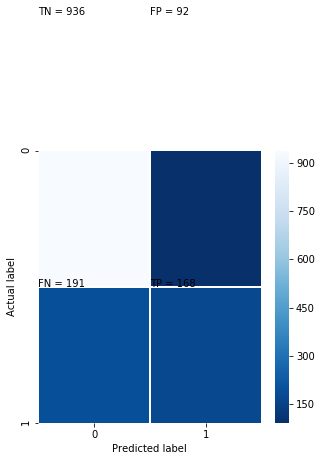

In [108]:
cm = confusion_matrix(y_val, y_pred)
annot_kws = {"ha": 'center',"va": 'center'}


plt.figure(figsize=(5,5))
sns.heatmap(cm, fmt="d", linewidths=.5, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
s = [['TN','FP'], ['FN', 'TP']]

for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()